In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.1


In [3]:
# to fix cudnn issues with NVIDIA RTX cards
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
# !wget --no-check-certificate \
#     https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
#     -O /tmp/daily-min-temperatures.csv

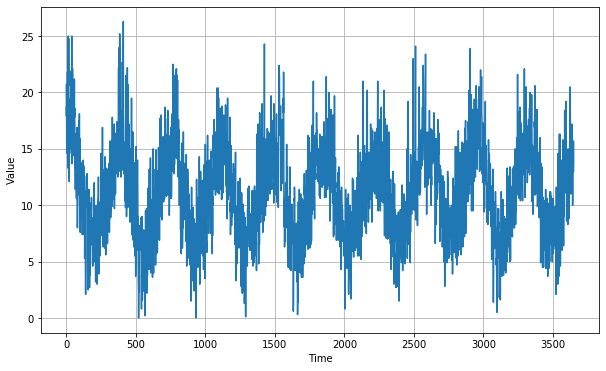

In [6]:
import csv
time_step = []
temps = []

with open('daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 4s 383ms/step - loss: 31.1549 - mae: 31.6551
Epoch 2/100
10/10 [==============================] - 0s 25ms/step - loss: 30.5753 - mae: 31.0783
Epoch 3/100
10/10 [==============================] - 0s 25ms/step - loss: 29.7469 - mae: 30.1792
Epoch 4/100
10/10 [==============================] - 0s 25ms/step - loss: 28.5816 - mae: 29.0582
Epoch 5/100
10/10 [==============================] - 0s 26ms/step - loss: 27.1349 - mae: 27.6970
Epoch 6/100
10/10 [==============================] - 0s 24ms/step - loss: 25.5287 - mae: 25.9975
Epoch 7/100
10/10 [==============================] - 0s 26ms/step - loss: 23.3412 - mae: 23.8407
Epoch 8/100
10/10 [==============================] - 0s 25ms/step - loss: 20.6980 - mae: 21.1120
Epoch 9/100
10/10 [==============================] - 0s 25ms/step - loss: 17.4437 - mae: 17.8083
Epoch 10/100
10/10 [====

10/10 [==============================] - 0s 26ms/step - loss: 4.9941 - mae: 5.8044
Epoch 86/100
10/10 [==============================] - 0s 27ms/step - loss: 6.3527 - mae: 6.8078
Epoch 87/100
10/10 [==============================] - 0s 26ms/step - loss: 9.9541 - mae: 11.0309
Epoch 88/100
10/10 [==============================] - 0s 26ms/step - loss: 17.8499 - mae: 18.0064
Epoch 89/100
10/10 [==============================] - 0s 27ms/step - loss: 21.1751 - mae: 22.3715
Epoch 90/100
10/10 [==============================] - 0s 26ms/step - loss: 40.0324 - mae: 38.9920
Epoch 91/100
10/10 [==============================] - 0s 25ms/step - loss: 25.1629 - mae: 27.7798
Epoch 92/100
10/10 [==============================] - 0s 27ms/step - loss: 37.2872 - mae: 39.4730
Epoch 93/100
10/10 [==============================] - 0s 26ms/step - loss: 44.6637 - mae: 43.7513
Epoch 94/100
10/10 [==============================] - 0s 26ms/step - loss: 38.6461 - mae: 38.1247
Epoch 95/100
10/10 [==================

[1e-08, 0.0001, 0, 60]

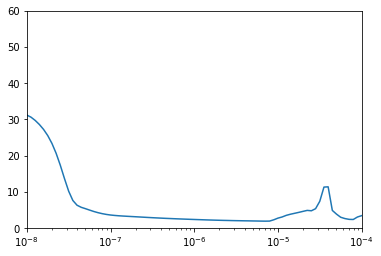

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 3s 110ms/step - loss: 9.9623 - mae: 10.5788
Epoch 2/150
25/25 [==============================] - 0s 12ms/step - loss: 2.5936 - mae: 3.0496
Epoch 3/150
25/25 [==============================] - 0s 12ms/step - loss: 1.9328 - mae: 2.3879
Epoch 4/150
25/25 [==============================] - 0s 12ms/step - loss: 1.8620 - mae: 2.3160
Epoch 5/150
25/25 [==============================] - 0s 12ms/step - loss: 1.8200 - mae: 2.2715
Epoch 6/150
25/25 [==============================] - 0s 12ms/step - loss: 1.7917 - mae: 2.2419
Epoch 7/150
25/25 [==============================] - 0s 12ms/step - loss: 1.7631 - mae: 2.2129
Epoch 8/150
25/25 [==============================] - 0s 12ms/step - loss: 1.7460 - mae: 2.1938
Epoch 9/150
25/25 [==============================] - 0s 12ms/step - loss: 1.7219 - mae: 2.1688
Epoch 10/150
25/25 [==============================] - 0s 12ms/step - loss: 1.7014 - mae: 2.1483
Epoch 11/150
25/25 [===========================

25/25 [==============================] - 0s 12ms/step - loss: 1.5048 - mae: 1.9455
Epoch 87/150
25/25 [==============================] - 0s 12ms/step - loss: 1.5035 - mae: 1.9446
Epoch 88/150
25/25 [==============================] - 0s 12ms/step - loss: 1.5040 - mae: 1.9455
Epoch 89/150
25/25 [==============================] - 0s 12ms/step - loss: 1.5031 - mae: 1.9434
Epoch 90/150
25/25 [==============================] - 0s 12ms/step - loss: 1.5014 - mae: 1.9428
Epoch 91/150
25/25 [==============================] - 0s 12ms/step - loss: 1.5035 - mae: 1.9442
Epoch 92/150
25/25 [==============================] - 0s 12ms/step - loss: 1.5030 - mae: 1.9436
Epoch 93/150
25/25 [==============================] - 0s 11ms/step - loss: 1.5002 - mae: 1.9407
Epoch 94/150
25/25 [==============================] - 0s 12ms/step - loss: 1.4988 - mae: 1.9393
Epoch 95/150
25/25 [==============================] - 0s 12ms/step - loss: 1.4974 - mae: 1.9377
Epoch 96/150
25/25 [==============================] -

In [13]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

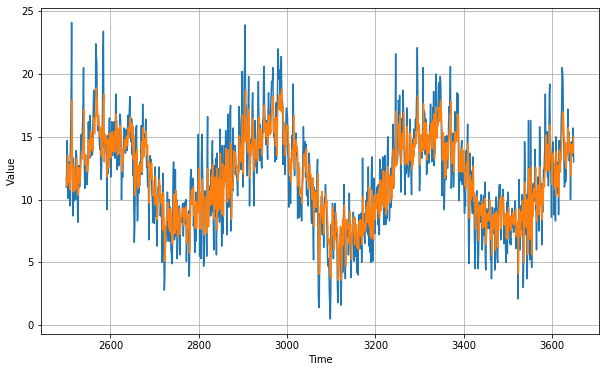

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7814171

In [16]:
print(rnn_forecast)

[11.665219 11.04954  12.271893 ... 13.672772 13.80576  15.02356 ]
